In [103]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch_dct as dct

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Low rank tensor

In [104]:
import random
random.seed(5)

In [105]:
tensor_size  = 128*128*3

In [191]:
tensor = torch.zeros([128,128*3])

for i in range(128):
    a = random.random()
    b = random.random()*2
    c = random.random()
    for j in range(128*3):
        index = j /(128*3)
        if random.random()>0.2:
            tensor[i][j] = a*index -b*index*index+c*index*index*index+ random.random()/10
tensor = tensor.reshape([128,128,3])

In [113]:
def get_probability_tensor(tensor):
    normalize_base =torch.abs(tensor).max()
    quantized_tensor = torch.floor(((tensor / normalize_base +1)/2)*255 )

    unique_values, counts = torch.unique(quantized_tensor, return_counts=True)
    probabilities = counts.float() / quantized_tensor.numel()  # Probability of each unique value

    # Step 5: Create a mapping of quantized values to probabilities
    value_to_prob = {val.item(): prob.item() for val, prob in zip(unique_values, probabilities)}

    # Step 6: Map the probabilities back to the quantized tensor
    probability_tensor = quantized_tensor.clone()
    for val in unique_values:
        probability_tensor[quantized_tensor == val] = value_to_prob[val.item()]
    return probability_tensor

In [192]:
dct_tensor = dct.dct_3d(tensor)
fft_tensor = torch.fft.rfft(tensor[tensor!=0])

In [193]:
print(torch.mean(torch.special.entr(get_probability_tensor(abs(dct_tensor)))))
print(torch.mean(torch.special.entr(get_probability_tensor(abs(fft_tensor)))))

tensor(0.1570)
tensor(0.1363)


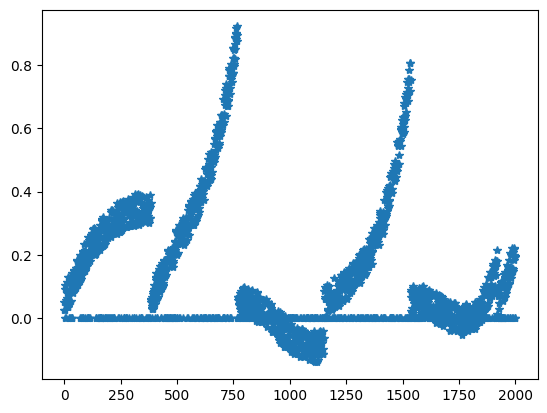

In [194]:
plt.figure()
plt.plot(tensor.reshape(tensor.numel())[0:2000],"*")

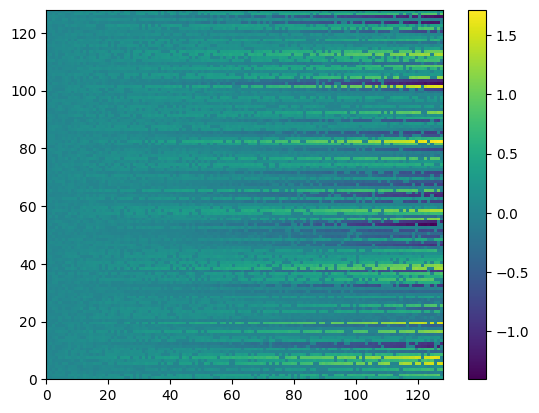

In [195]:
plt.figure()
plt.pcolormesh(tensor[:,:,0])
plt.colorbar()

## Get tensor charateristics

In [6]:
# actual_rank= calculate_cp_rank(tensor.numpy())
# print("The acutal rank of the tensor is: ", actual_rank)

In [7]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.4012451171875


## Tensor compression

#### Jpeg

In [8]:
lowrank_jpeg_ratio = []
lowrank_jpeg_snr =[]
lowrank_jpeg_mse = []

In [9]:
for i in range(10):
    jpeg_quality = 55 + i *5
    normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor, jpeg_quality)
    print("Compressed size: ", compressed_size_jpeg)

    reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape,normalize_base, scale,zero_point, encoded_data )
    snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    print("Reconstruction snr (dB): ", snr_jpeg)
    print("Reconstruction mse: ", mse_jpeg)
    
    lowrank_jpeg_ratio.append((tensor_size*4) / compressed_size_jpeg)
    lowrank_jpeg_snr.append(snr_jpeg)
    lowrank_jpeg_mse.append(mse_jpeg / torch.max(tensor).item())

Compressed size:  13202
Reconstruction snr (dB):  5.995430946350098
Reconstruction mse:  0.050096486
Compressed size:  14292
Reconstruction snr (dB):  6.42056405544281
Reconstruction mse:  0.04542489
Compressed size:  15526
Reconstruction snr (dB):  6.825674772262573
Reconstruction mse:  0.041379273
Compressed size:  16990
Reconstruction snr (dB):  7.22423791885376
Reconstruction mse:  0.03775083
Compressed size:  18622
Reconstruction snr (dB):  7.593783736228943
Reconstruction mse:  0.034671444
Compressed size:  20884
Reconstruction snr (dB):  7.977809309959412
Reconstruction mse:  0.031737257
Compressed size:  23864
Reconstruction snr (dB):  8.32700490951538
Reconstruction mse:  0.02928531
Compressed size:  28213
Reconstruction snr (dB):  8.635542392730713
Reconstruction mse:  0.027276965
Compressed size:  36763
Reconstruction snr (dB):  8.898394107818604
Reconstruction mse:  0.025675029
Compressed size:  63519
Reconstruction snr (dB):  9.075320959091187
Reconstruction mse:  0.024650

#### Tensor decomposition

In [10]:
lowrank_decomposition_ratio =[]
lowrank_decomposition_snr = []
lowrank_decomposition_mse = []

In [11]:
for i in range(10):
    decom_rank = i +1
    factors, compressed_size_decomposition = compressor_decomposition(tensor, decom_rank)
    print("Compressed size: ", compressed_size_decomposition)
    reconstructed_tensor_decomposition = decompressor_decomposition(factors )
    snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition)
    mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition)
    print("Reconstruction snr (dB): ", snr_decomposition)
    print("Reconstruction mse: ", mse_decomposition)

    lowrank_decomposition_ratio.append((tensor_size*4) / compressed_size_decomposition)
    lowrank_decomposition_snr.append(snr_decomposition)
    lowrank_decomposition_mse.append(mse_decomposition / torch.max(tensor).item())

Compressed size:  1036
Reconstruction snr (dB):  2.624938189983368
Reconstruction mse:  0.108857036
Compressed size:  2072
Reconstruction snr (dB):  2.6688918471336365
Reconstruction mse:  0.107760884
Compressed size:  3108
Reconstruction snr (dB):  2.714203894138336
Reconstruction mse:  0.1066424
Compressed size:  4144
Reconstruction snr (dB):  2.7623698115348816
Reconstruction mse:  0.10546621
Compressed size:  5180
Reconstruction snr (dB):  2.8090739250183105
Reconstruction mse:  0.1043381
Compressed size:  6216
Reconstruction snr (dB):  2.8565233945846558
Reconstruction mse:  0.10320435
Compressed size:  7252
Reconstruction snr (dB):  2.9012173414230347
Reconstruction mse:  0.1021477
Compressed size:  8288
Reconstruction snr (dB):  2.94852614402771
Reconstruction mse:  0.10104102
Compressed size:  9324
Reconstruction snr (dB):  2.994903028011322
Reconstruction mse:  0.09996778
Compressed size:  10360
Reconstruction snr (dB):  3.0368974804878235
Reconstruction mse:  0.09900579


#### Regression

In [12]:
lowrank_regression_ratio = []
lowrank_regression_snr = []
lowrank_regression_mse = []

In [13]:
for i in range(10):
    regression_rank = i+1
    factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor, regression_rank)
    print("Compressed size: ", compressed_size_regression)

    reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
    snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
    mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
    print("Reconstruction snr (dB): ", snr_regression)
    print("Reconstruction mse: ", mse_regression)

    lowrank_regression_ratio.append((tensor_size*4) / compressed_size_regression)
    lowrank_regression_snr.append(snr_regression)
    lowrank_regression_mse.append(mse_regression / torch.max(tensor).item())

Compressed size:  12800.0
Reconstruction snr (dB):  6.093888282775879
Reconstruction mse:  0.04897354
Compressed size:  13312.0
Reconstruction snr (dB):  6.114271879196167
Reconstruction mse:  0.04874422
Compressed size:  13824.0
Reconstruction snr (dB):  6.13179087638855
Reconstruction mse:  0.048547987
Compressed size:  14336.0
Reconstruction snr (dB):  6.150537729263306
Reconstruction mse:  0.04833888
Compressed size:  14848.0
Reconstruction snr (dB):  6.173396110534668
Reconstruction mse:  0.048085123
Compressed size:  15360.0
Reconstruction snr (dB):  6.194706559181213
Reconstruction mse:  0.04784975
Compressed size:  15872.0
Reconstruction snr (dB):  6.2180763483047485
Reconstruction mse:  0.047592957
Compressed size:  16384.0
Reconstruction snr (dB):  6.239036917686462
Reconstruction mse:  0.047363807
Compressed size:  16896.0
Reconstruction snr (dB):  6.254062056541443
Reconstruction mse:  0.047200233
Compressed size:  17408.0
Reconstruction snr (dB):  6.272825598716736
Reconst

#### Sketch ML

In [14]:
lowrank_sketchml_ratio = []
lowrank_sketchml_snr = []
lowrank_sketchml_mse = []

In [15]:
for i in range (10):
    d = (i+1) * 0.1
    a = 13-i
    minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,d,a)
    print("Compressed size: ", compressed_size_sketchml)

    reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
    snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    print("Reconstruction snr (dB): ", snr_sketchml)
    print("Reconstruction mse: ", mse_sketchml)
    
    lowrank_sketchml_ratio.append((tensor_size*4) / compressed_size_sketchml)
    lowrank_sketchml_snr.append(snr_sketchml)
    lowrank_sketchml_mse.append( mse_sketchml / torch.max(tensor).item())

Compressed size:  41188
Reconstruction snr (dB):  4.686252474784851
Reconstruction mse:  0.06772127
Compressed size:  68805
Reconstruction snr (dB):  9.63124692440033
Reconstruction mse:  0.021688307
Compressed size:  91484
Reconstruction snr (dB):  14.251059293746948
Reconstruction mse:  0.007485906
Compressed size:  108894
Reconstruction snr (dB):  18.195180892944336
Reconstruction mse:  0.003018785
Compressed size:  121253
Reconstruction snr (dB):  21.082661151885986
Reconstruction mse:  0.0015526884
Compressed size:  128303
Reconstruction snr (dB):  22.381105422973633
Reconstruction mse:  0.001151436
Compressed size:  130462
Reconstruction snr (dB):  23.529667854309082
Reconstruction mse:  0.0008838603
Compressed size:  127130
Reconstruction snr (dB):  23.26949119567871
Reconstruction mse:  0.00093842874
Compressed size:  118895
Reconstruction snr (dB):  22.006118297576904
Reconstruction mse:  0.0012552742
Compressed size:  105415
Reconstruction snr (dB):  20.247859954833984
Recons

# Plot

Text(0, 0.5, 'Reconstruction SNR [dB]')

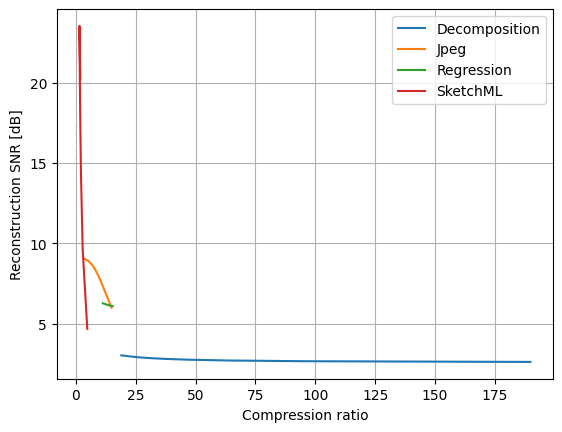

In [16]:
plt.figure()
plt.plot(lowrank_decomposition_ratio, lowrank_decomposition_snr,label ="Decomposition")
plt.plot(lowrank_jpeg_ratio, lowrank_jpeg_snr,label ="Jpeg")
plt.plot(lowrank_regression_ratio, lowrank_regression_snr,label ="Regression")
plt.plot(lowrank_sketchml_ratio, lowrank_sketchml_snr,label ="SketchML")
plt.legend()
plt.grid()
plt.xlabel("Compression ratio")
plt.ylabel("Reconstruction SNR [dB]")

# Plotting